In [1]:
import pandas as pd
import numpy as np

df_sales = pd.read_excel(r'C:\Users\yogan\OneDrive\Desktop\reliance\Reliance ResQ Sales data & Claim Data.xlsx', sheet_name=0)
df_claims = pd.read_excel(r'C:\Users\yogan\OneDrive\Desktop\reliance\Reliance ResQ Sales data & Claim Data.xlsx', sheet_name=1)

df_sales.shape, df_claims.shape

((68481, 28), (144, 12))

In [2]:
df_sales['Brand'] = df_sales['Brand'].replace(
     {
    'Idea': 'Lenovo',
    'Pad': 'Redmi',
    'GooglePixel': 'Google'
})

df_sales = df_sales.drop(['Transaction Total','Transaction Date','Week','Plan ID','Mobile No','City','Pincode','Product Description','Duration','Duration.1','Manufacturer Warranty','Plan Tenure','Serial No./IMEI'], axis = 1)

In [3]:
df_claims_25 = df_claims[df_claims['Day of Call_Date'].dt.year == 2025].copy()
df_claims_25['Warranty Type'] = df_claims_25['Warranty Type'].replace({
    'Screen Protection': 'Cracked Screen'
})

df_claims_25['Product Brand(Group)'] = df_claims_25['Product Brand(Group)'].replace({'OPPO': 'Oppo'})

df_claims_25['One time deductible'] = df_claims_25['One time deductible'].fillna(999)
# df_claims_25 = df_claims_25.dropna(subset=['Claim_Amount'])

df_sales = df_sales.rename(columns = {'Zopper Share': 'Plan Selling Price'})

In [4]:
df_sales['Plan Start Date'] = pd.to_datetime(df_sales['Plan Start Date'], errors='coerce')
df_sales['Plan End Date']   = pd.to_datetime(df_sales['Plan End Date'], errors='coerce')

df_sales_25 = df_sales[df_sales['Plan Start Date'].dt.year == 2025].copy()

start_date = df_sales_25['Plan Start Date']
end_date = df_sales_25['Plan End Date']

df_sales_25['Coverage Days'] = (df_sales_25['Plan End Date'] - df_sales_25['Plan Start Date']).dt.days.clip(lower=1)
valuation_date = pd.to_datetime("2025-12-31")

df_sales_25['Exposure Days'] = (
    valuation_date - df_sales_25['Plan Start Date']
).dt.days
df_sales_25['Written Premium'] = df_sales_25['Zopper Shared ( Transfer Price )']*1.18

df_sales_25['Zopper Earned Premium'] = (df_sales_25['Written Premium'] * (df_sales_25['Exposure Days']/ df_sales_25['Coverage Days']))
print("Zopper Earned Premium: ",df_sales_25['Zopper Earned Premium'].sum())

Zopper Earned Premium:  9387094.518688496


In [5]:
df_sales_25['Gross Premium'] = df_sales_25['Plan Selling Price']
df_sales_25['Gross Premium'].sum()

np.int64(142263481)

In [6]:
df_sales_25['Earned Premium'] = (
    df_sales_25['Gross Premium'] *
    (df_sales_25['Exposure Days'] / df_sales_25['Coverage Days'])
)
df_sales_25['Earned Premium'].sum()

np.float64(51701903.20773289)

C:\Users\yogan\AppData\Local\Temp\ipykernel_19792\1757707765.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(brand_ep.index, rotation=45, ha='right')


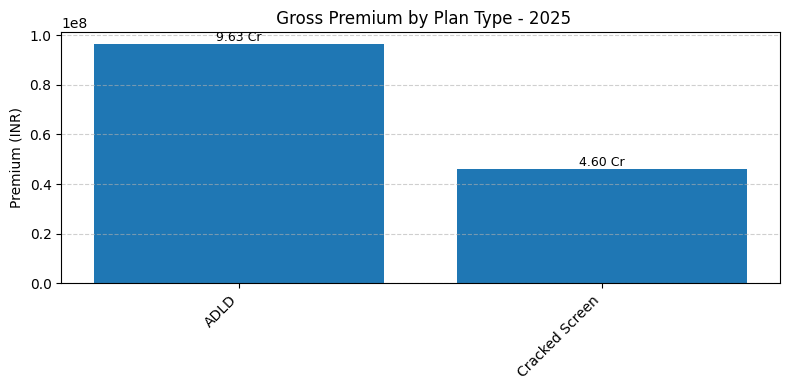

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

brand_ep = (
    df_sales_25
    .groupby('Plan Type')['Gross Premium']
    .sum()
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(brand_ep.index, brand_ep.values)

ax.set_title(' Gross Premium by Plan Type - 2025')
ax.set_ylabel('Premium (INR)')
ax.set_xticklabels(brand_ep.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f'{h/1e7:.2f} Cr',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


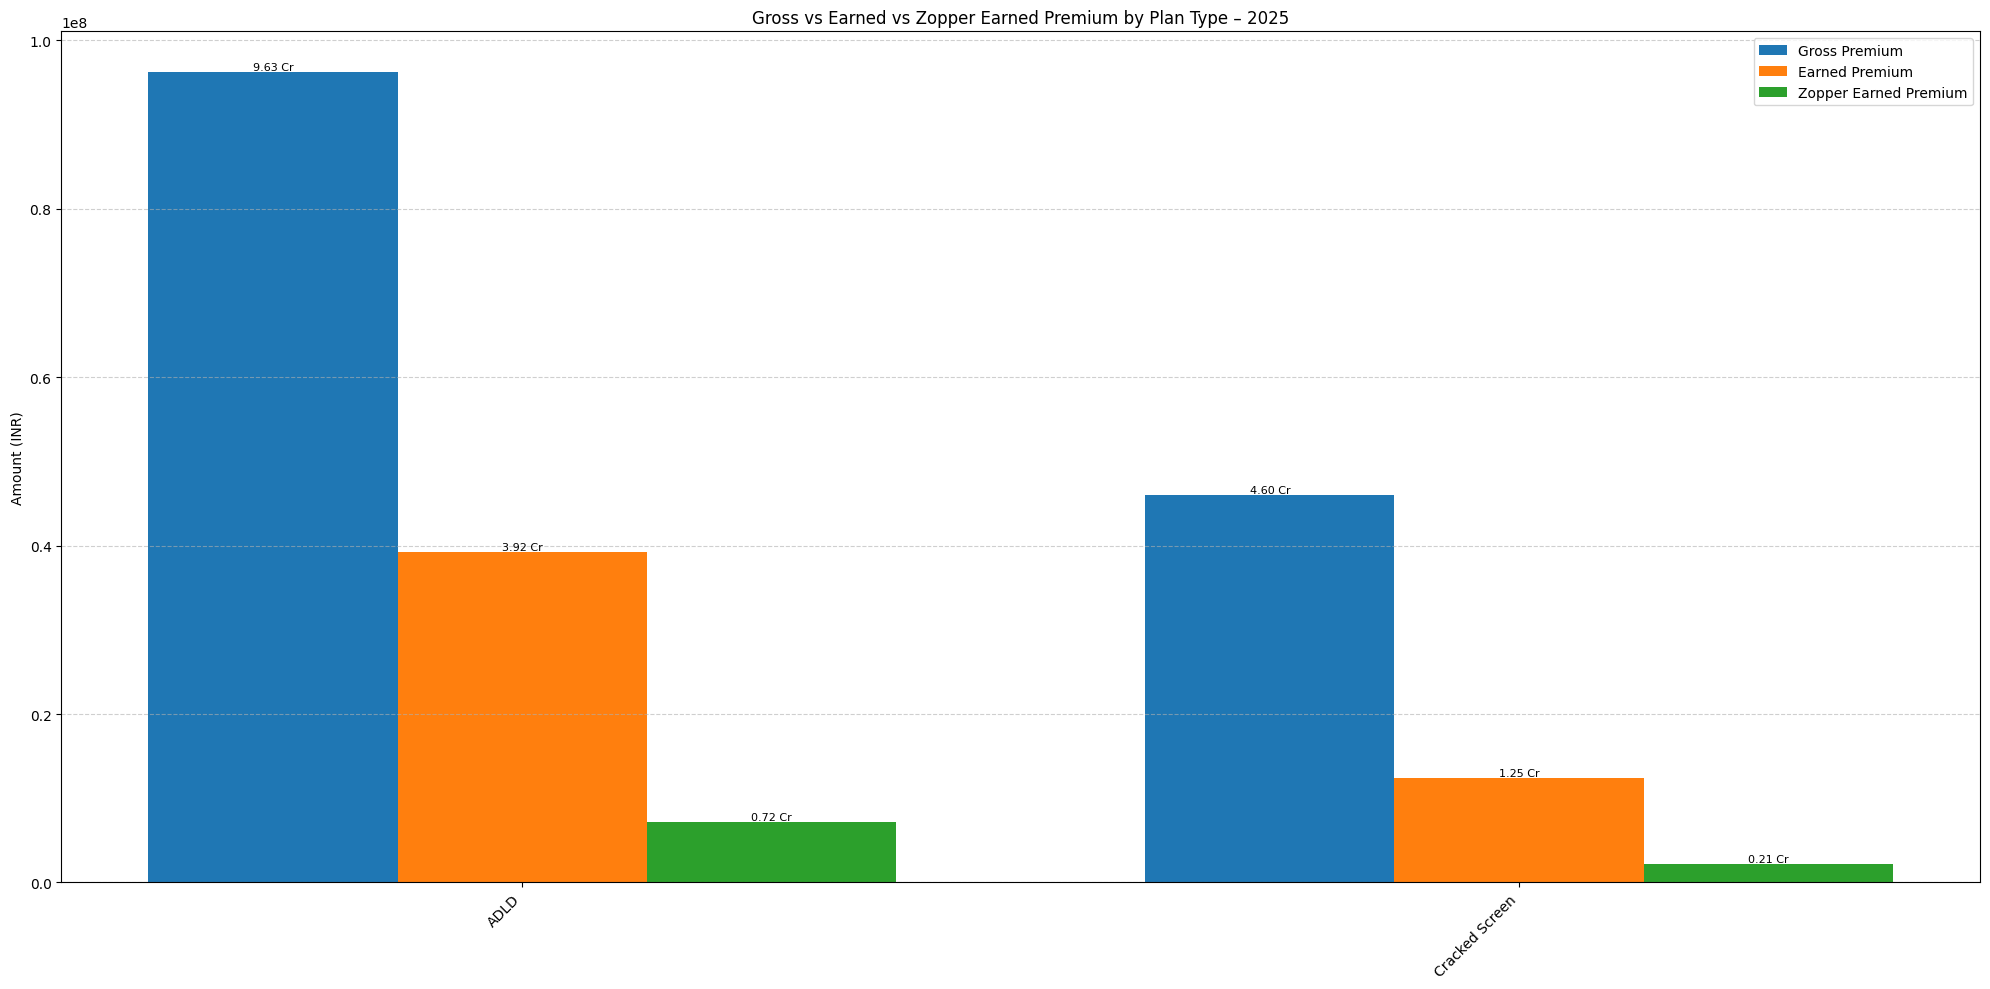

In [8]:
gross_premium_by_brand = (
    df_sales_25
    .groupby('Plan Type')['Gross Premium']
    .sum()
)

earned_premium_by_brand = (
    df_sales_25
    .groupby('Plan Type')['Earned Premium']
    .sum()
)

zopper_earned_by_brand = (
    df_sales_25
    .groupby('Plan Type')['Zopper Earned Premium']
    .sum()
)

brand_data = (
    pd.concat(
        [
            gross_premium_by_brand,
            earned_premium_by_brand,
            zopper_earned_by_brand
        ],
        axis=1
    )
    .fillna(0)
)

brand_data.columns = [
    'Gross Premium',
    'Earned Premium',
    'Zopper Earned Premium'
]

brand_data = brand_data.sort_values(
    'Earned Premium',
    ascending=False
)

x = np.arange(len(brand_data))
width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

b0 = ax.bar(x - width, brand_data['Gross Premium'], width, label='Gross Premium')
b1 = ax.bar(x,         brand_data['Earned Premium'], width, label='Earned Premium')
b2 = ax.bar(x + width, brand_data['Zopper Earned Premium'], width, label='Zopper Earned Premium')

ax.set_title('Gross vs Earned vs Zopper Earned Premium by Plan Type – 2025')
ax.set_ylabel('Amount (INR)')
ax.set_xticks(x)
ax.set_xticklabels(brand_data.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

for bars in [b0, b1, b2]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h,
                f'{h / 1e7:.2f} Cr',
                ha='center',
                va='bottom',
                fontsize=8
            )

plt.tight_layout()
plt.show()


In [9]:
df_claims_25['Warranty Type'] = df_claims_25['Warranty Type'].replace({
    'Screen Protection': 'Cracked Screen'
})

In [10]:
brand_data['Net Claims'] = (
    df_claims_25
    .groupby('Warranty Type')['Zopper\'s Cost']
    .sum()
)


brand_data['Loss Ratio (%)'] = (
    brand_data['Net Claims'] /
    brand_data['Zopper Earned Premium'] * 100
).replace([np.inf, -np.inf], 0).fillna(0)


In [11]:
brand_data['Loss Ratio (%)'].sum()

np.float64(62.715076716099375)

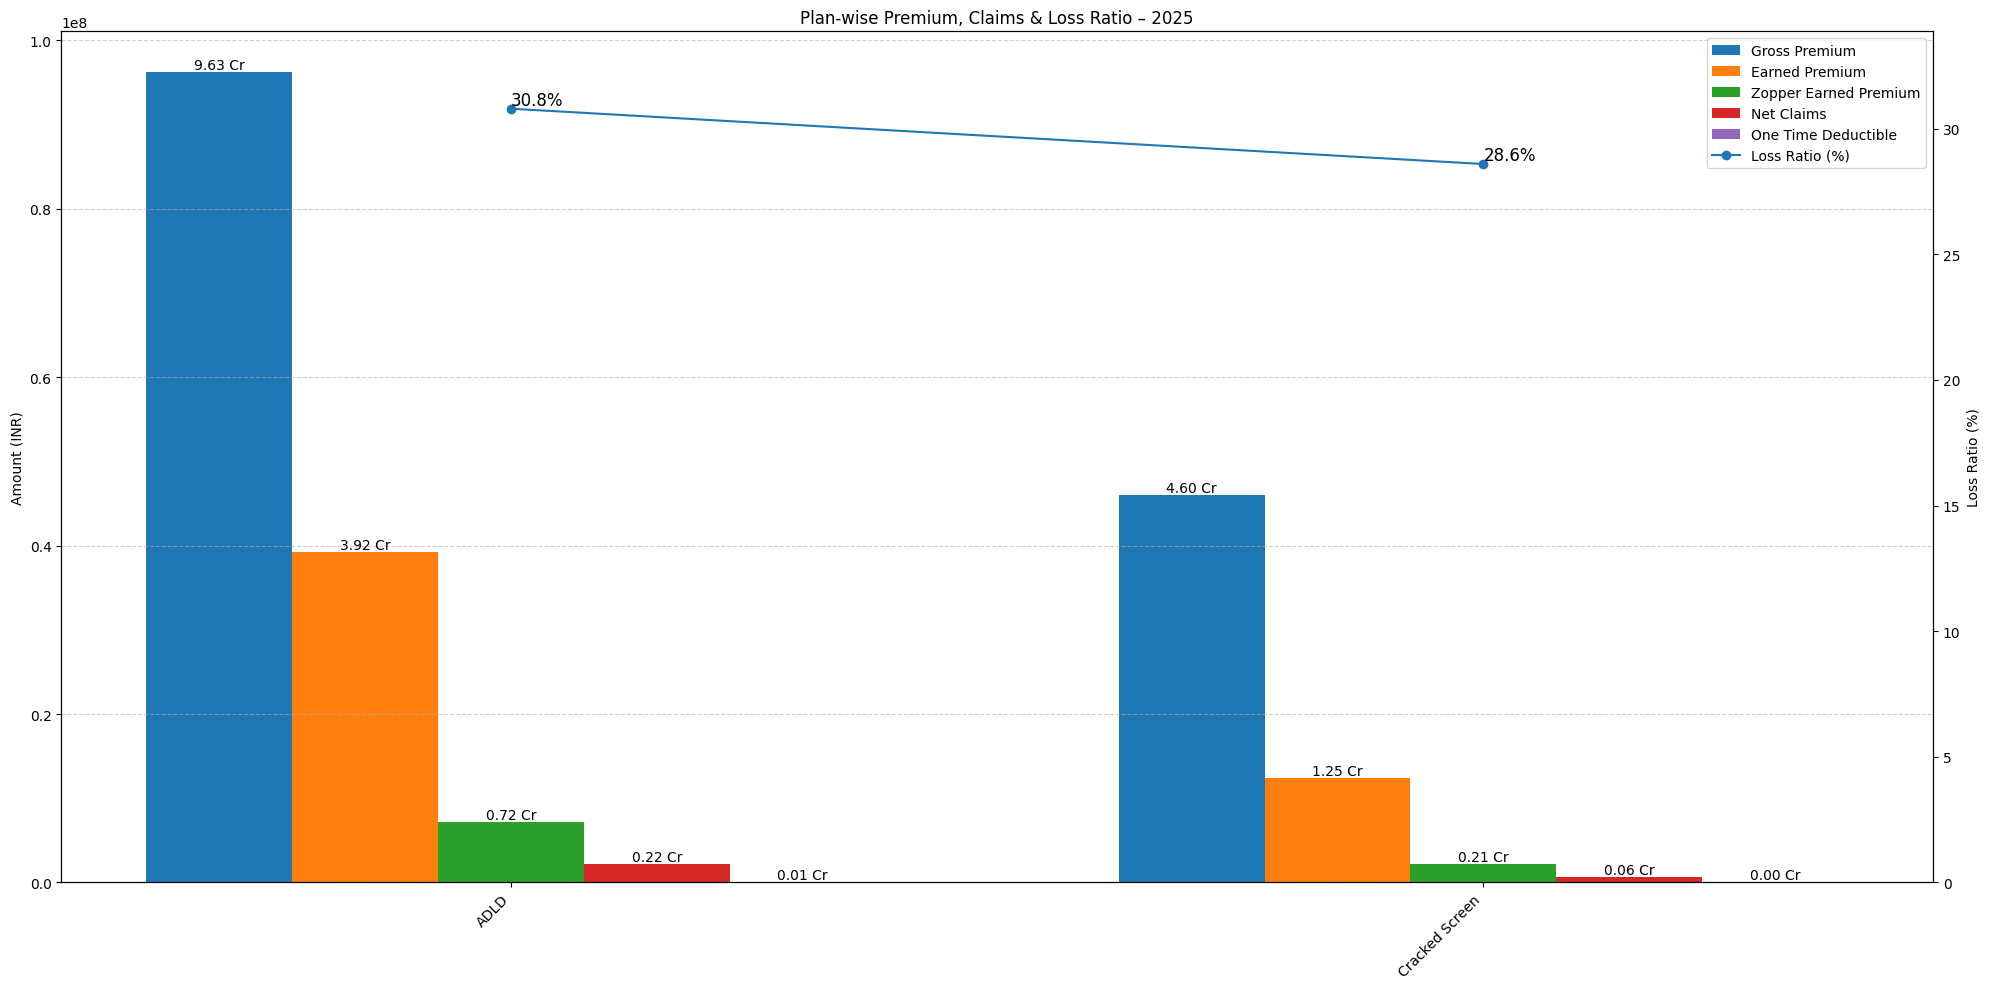

In [12]:
gross_premium_by_brand = (
    df_sales_25
    .groupby('Plan Type')['Gross Premium']
    .sum()
)

earned_premium_by_brand = (
    df_sales_25
    .groupby('Plan Type')['Earned Premium']
    .sum()
)

zopper_earned_by_brand = (
    df_sales_25
    .groupby('Plan Type')['Zopper Earned Premium']
    .sum()
)

df_claims_25['Net Claim Cost'] = (
    df_claims_25["Zopper's Cost"] - df_claims_25['One time deductible']
)

net_claim_by_brand = (
    df_claims_25
    .groupby('Warranty Type')['Net Claim Cost']
    .sum()
)

deductible_by_brand = (
    df_claims_25
    .groupby('Warranty Type')['One time deductible']
    .sum()
)

brand_data = (
    pd.concat(
        [
            gross_premium_by_brand,
            earned_premium_by_brand,
            zopper_earned_by_brand,
            net_claim_by_brand,
            deductible_by_brand
        ],
        axis=1
    )
    .fillna(0)
)

brand_data.columns = [
    'Gross Premium',
    'Earned Premium',
    'Zopper Earned Premium',
    'Net Claims',
    'One time deductible'
]

brand_data = brand_data.sort_values('Earned Premium', ascending=False)

brand_data['Loss Ratio (%)'] = (
    brand_data['Net Claims'] / brand_data['Zopper Earned Premium'] * 100
).replace([np.inf, -np.inf], 0).fillna(0)

x = np.arange(len(brand_data))
width = 0.15

fig, ax = plt.subplots(figsize=(20, 10))

b0 = ax.bar(x - 2*width, brand_data['Gross Premium'], width, label='Gross Premium')
b1 = ax.bar(x - width,   brand_data['Earned Premium'], width, label='Earned Premium')
b2 = ax.bar(x,           brand_data['Zopper Earned Premium'], width, label='Zopper Earned Premium')
b3 = ax.bar(x + width,   brand_data['Net Claims'], width, label='Net Claims')
b4 = ax.bar(x + 2*width, brand_data['One time deductible'], width, label='One Time Deductible')

ax.set_title('Plan-wise Premium, Claims & Loss Ratio – 2025')
ax.set_ylabel('Amount (INR)')
ax.set_xticks(x)
ax.set_xticklabels(brand_data.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax.twinx()
ax2.plot(
    x,
    brand_data['Loss Ratio (%)'],
    marker='o',
    linewidth=1.5,
    label='Loss Ratio (%)'
)
ax2.set_ylabel('Loss Ratio (%)')
ax2.set_ylim(0, brand_data['Loss Ratio (%)'].max() * 1.1)

for i, v in enumerate(brand_data['Loss Ratio (%)']):
    ax2.text(
        x[i],
        v,
        f'{v:.1f}%',
        ha='left',
        va='bottom',
        fontsize=12
    )

for bars in [b0, b1, b2, b3, b4]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                h,
                f'{h/1e7:.2f} Cr',
                ha='center',
                va='bottom',
                fontsize=10
            )

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()


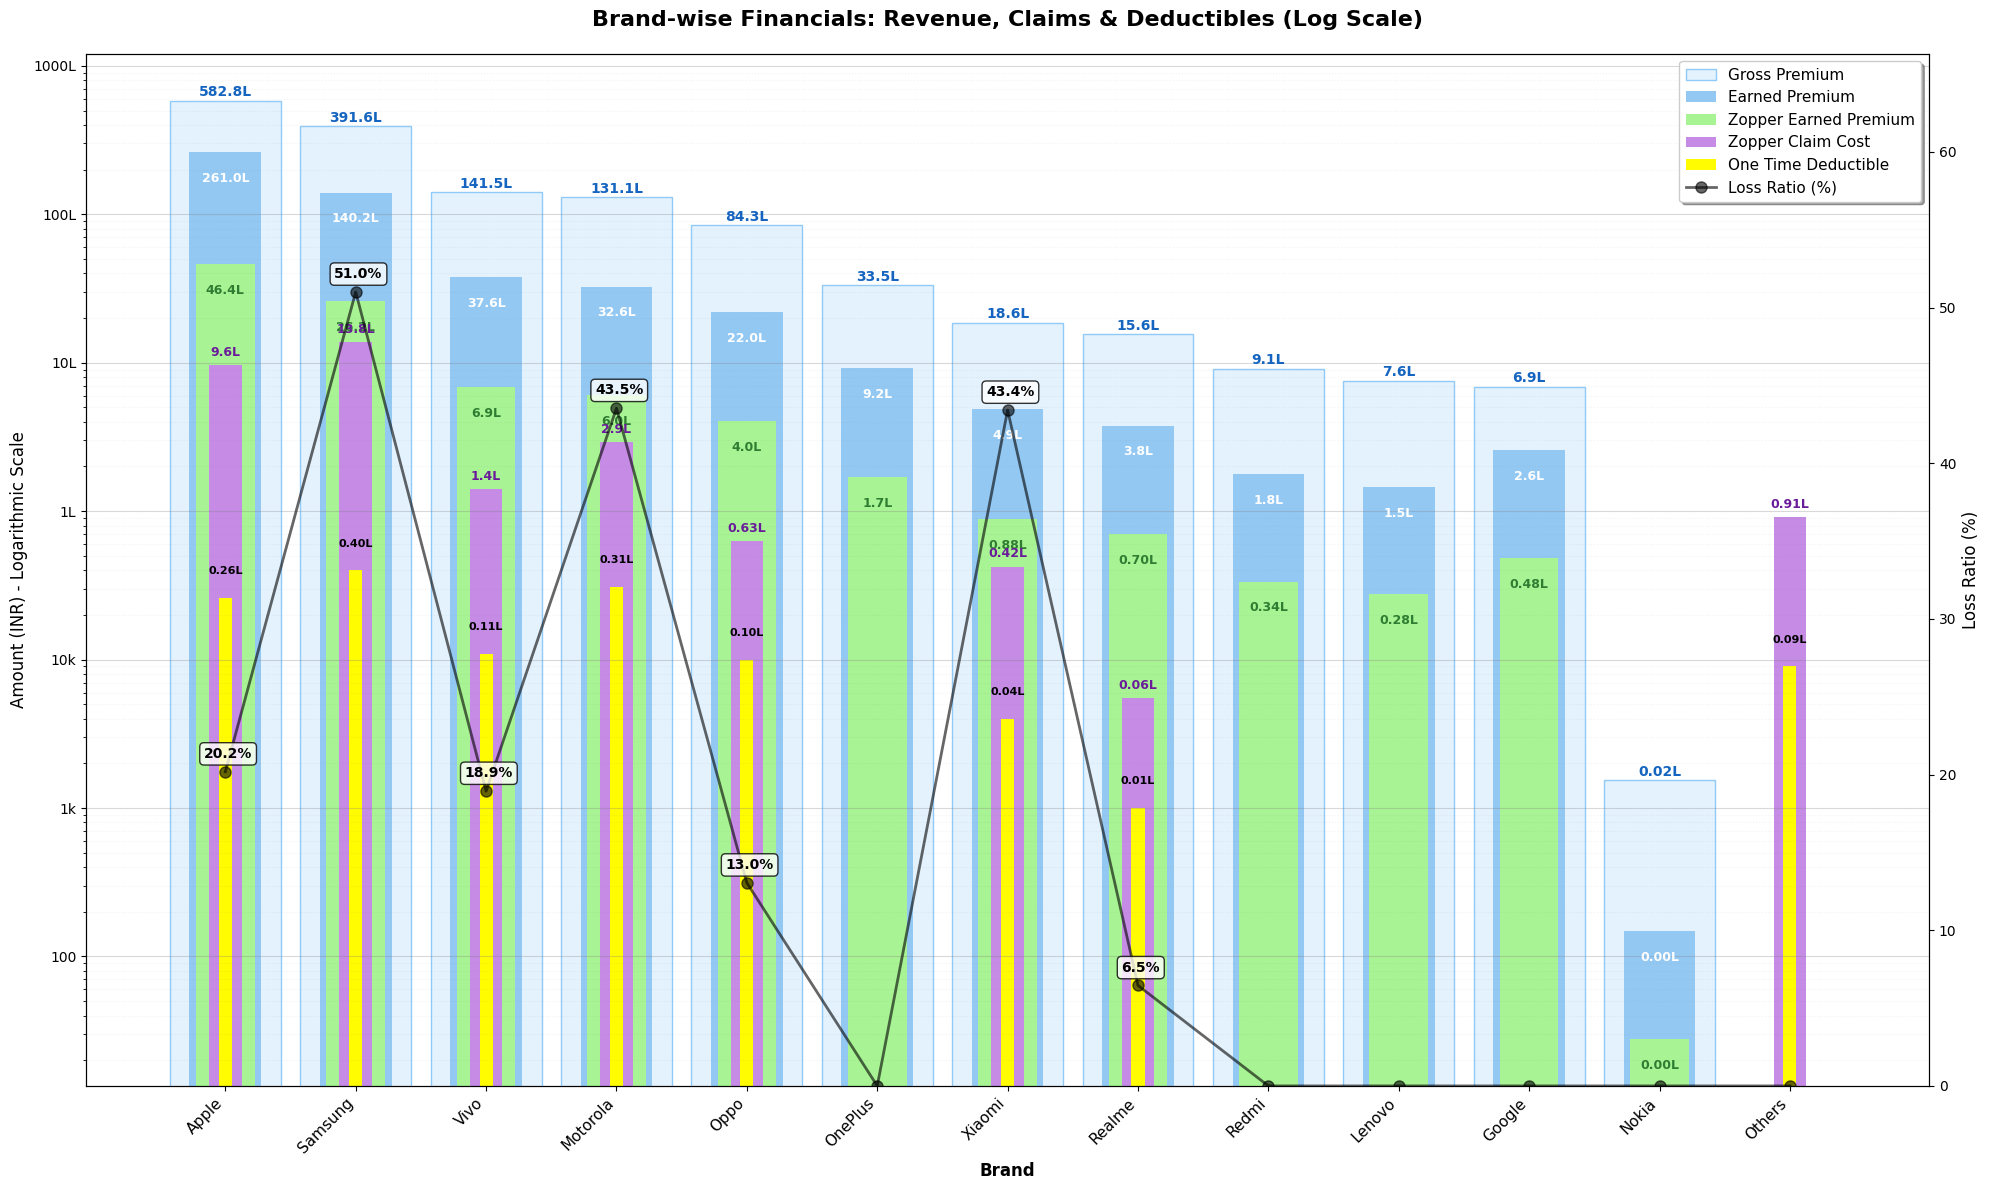

In [13]:
from matplotlib.ticker import FuncFormatter

gross_by_brand = df_sales_25.groupby('Brand')['Gross Premium'].sum()
earned_by_brand = df_sales_25.groupby('Brand')['Earned Premium'].sum()
zopper_earned_by_brand = df_sales_25.groupby('Brand')['Zopper Earned Premium'].sum()

zopper_claim_by_brand = (
    df_claims_25
    .groupby('Product Brand(Group)')["Zopper's Cost"]
    .sum()
)

deductible_by_brand = (
    df_claims_25
    .groupby('Product Brand(Group)')['One time deductible']
    .sum()
)

brand_data = (
    pd.concat(
        [
            gross_by_brand,
            earned_by_brand,
            zopper_earned_by_brand,
            zopper_claim_by_brand,
            deductible_by_brand
        ],
        axis=1
    )
    .fillna(0)
)

brand_data.columns = [
    'Gross Premium',
    'Earned Premium',
    'Zopper Earned Premium',
    "Zopper's Cost",
    'One time deductible'
]

brand_data = brand_data.sort_values('Gross Premium', ascending=False)

brand_data['Net Claims'] = (
    brand_data["Zopper's Cost"] - brand_data['One time deductible']
)

brand_data['Loss Ratio (%)'] = (
    brand_data['Net Claims'] / brand_data['Zopper Earned Premium'] * 100
).replace([np.inf, -np.inf], 0).fillna(0)

fig, ax1 = plt.subplots(figsize=(20, 12))
x = np.arange(len(brand_data))

w_gross = 0.85
w_earned = 0.55
w_zopper_earned = 0.45
w_claims = 0.25
w_deduct = 0.10  

bar_gross = ax1.bar(
    x,
    brand_data['Gross Premium'],
    width=w_gross,
    label='Gross Premium',
    color='#E3F2FD',
    edgecolor='#90CAF9',
    linewidth=1
)

bar_earned = ax1.bar(
    x,
    brand_data['Earned Premium'],
    width=w_earned,
    label='Earned Premium',
    color="#93C8F3"
)

bar_z_earned = ax1.bar(
    x,
    brand_data['Zopper Earned Premium'],
    width=w_zopper_earned,
    label='Zopper Earned Premium',
    color="#A8F393"
)

bar_claims = ax1.bar(
    x,
    brand_data["Zopper's Cost"],
    width=w_claims,
    label="Zopper Claim Cost",
    color="#C58BE5"
)

bar_deduct = ax1.bar(
    x,
    brand_data['One time deductible'],
    width=w_deduct,
    label='One Time Deductible',
    color="#FFFB00"
)

ax1.set_yscale('log')

def human_readable_lakhs(x, pos):
    if x >= 1e5:
        return f'{x/1e5:.0f}L'
    elif x >= 1e3:
        return f'{x/1e3:.0f}k'
    return str(int(x))

ax1.yaxis.set_major_formatter(FuncFormatter(human_readable_lakhs))

ax1.set_title(
    'Brand-wise Financials: Revenue, Claims & Deductibles (Log Scale)',
    fontsize=16,
    pad=20,
    fontweight='bold'
)

ax1.set_xlabel('Brand', fontsize=12, fontweight='bold')
ax1.set_ylabel('Amount (INR) - Logarithmic Scale', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(brand_data.index, rotation=45, ha='right', fontsize=11)

ax1.grid(axis='y', which='major', linestyle='-', alpha=0.3, color='gray')
ax1.grid(axis='y', which='minor', linestyle=':', alpha=0.1, color='gray')

ax2 = ax1.twinx()

ax2.plot(
    x,
    brand_data['Loss Ratio (%)'],
    color='black',
    marker='o',
    linewidth=2,
    markersize=8,
    alpha=0.6,
    label='Loss Ratio (%)'
)

ax2.set_ylabel('Loss Ratio (%)', fontsize=12)
ax2.set_ylim(0, brand_data['Loss Ratio (%)'].max() * 1.3)

def add_labels(bars, ax, color, y_offset_factor, font_size):
    for bar in bars:
        h = bar.get_height()
        if h <= 0:
            continue
        label = f'{h/1e5:.1f}L' if h >= 1e5 else f'{h/1e5:.2f}L'
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h * y_offset_factor,
            label,
            ha='center',
            va='bottom',
            fontsize=font_size,
            fontweight='bold',
            color=color
        )

add_labels(bar_gross, ax1, '#1565C0', 1.02, 10)
add_labels(bar_earned, ax1, 'white', 0.6, 9)
add_labels(bar_z_earned, ax1, '#2E7D32', 0.6, 9)
add_labels(bar_claims, ax1, '#6A1B9A', 1.1, 9)
add_labels(bar_deduct, ax1, "#000000", 1.4, 8)

for i, val in enumerate(brand_data['Loss Ratio (%)']):
    if val > 0:
        ax2.annotate(
            f'{val:.1f}%',
            xy=(x[i], val),
            xytext=(2, 10),
            textcoords='offset points',
            ha='center',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
        )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper right',
    fontsize=11,
    frameon=True,
    shadow=True
)

plt.tight_layout()
plt.show()


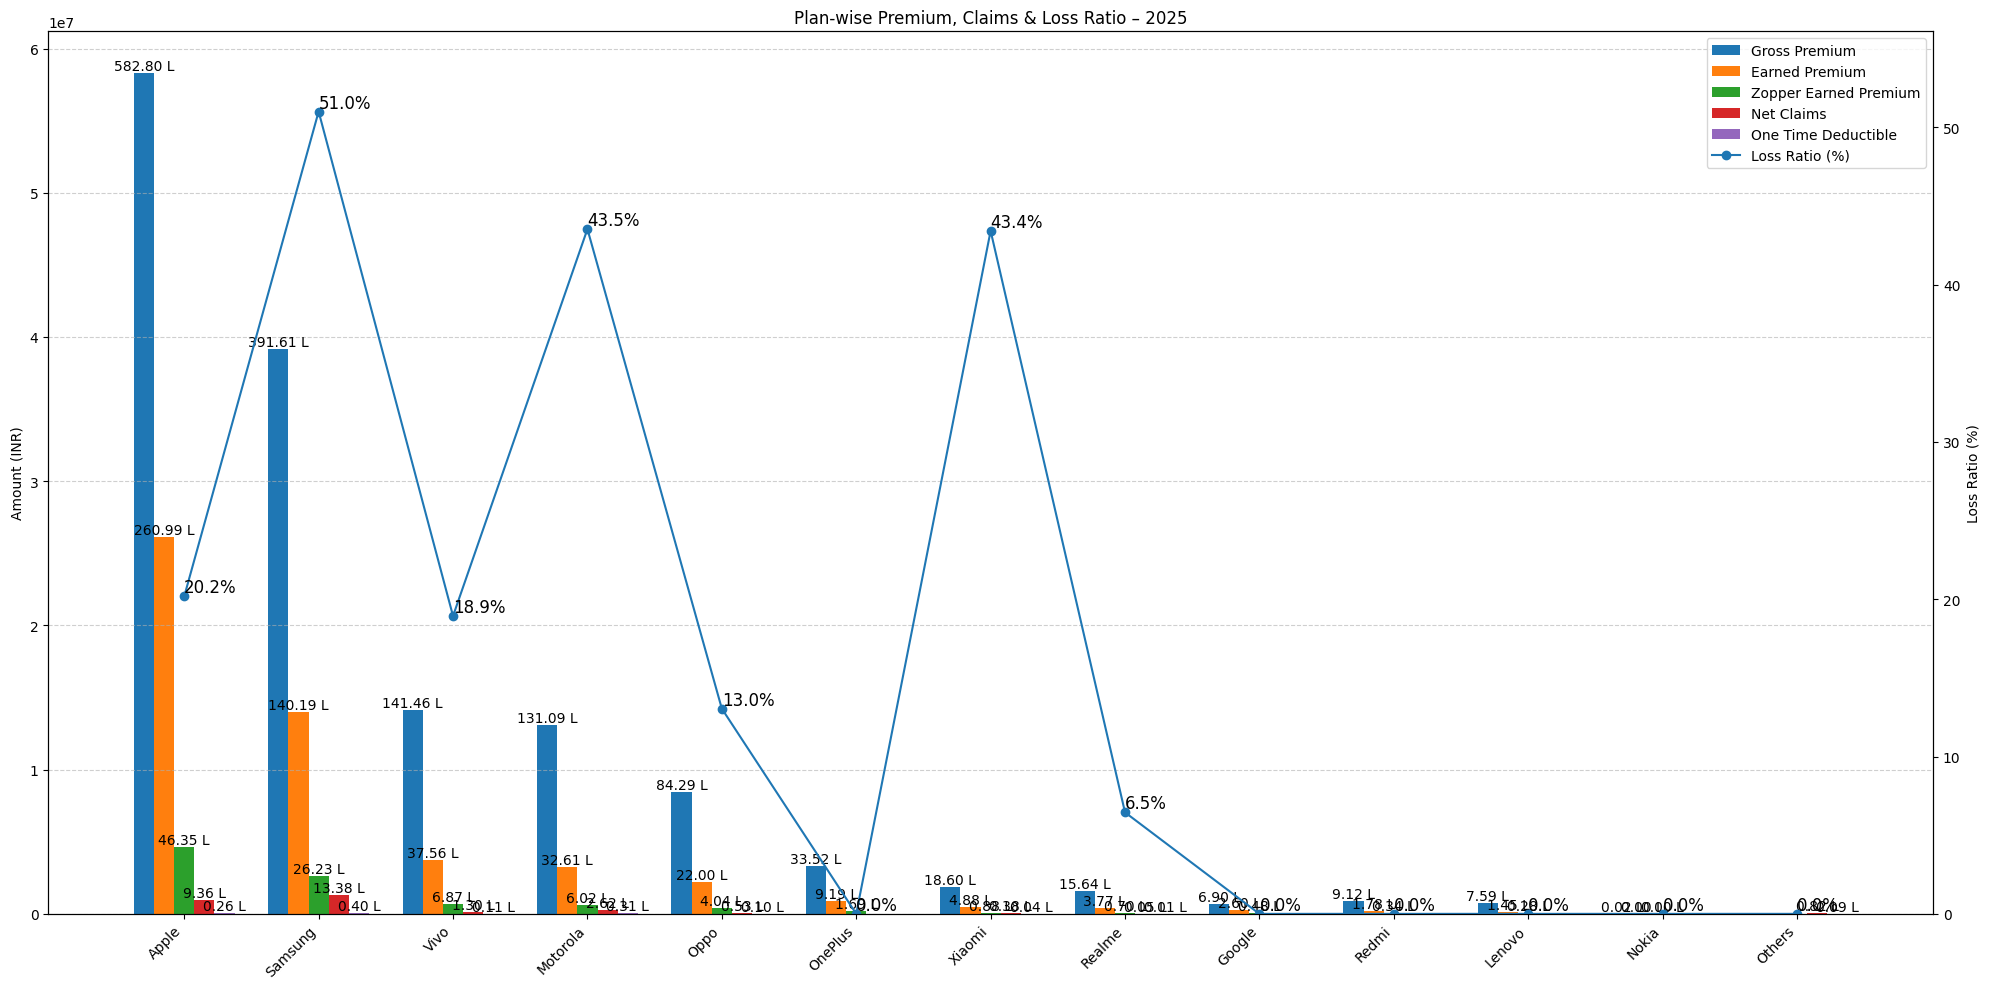

In [14]:
gross_premium_by_brand = (
    df_sales_25
    .groupby('Brand')['Gross Premium']
    .sum()
)

earned_premium_by_brand = (
    df_sales_25
    .groupby('Brand')['Earned Premium']
    .sum()
)

zopper_earned_by_brand = (
    df_sales_25
    .groupby('Brand')['Zopper Earned Premium']
    .sum()
)

df_claims_25['Net Claim Cost'] = (
    df_claims_25["Zopper's Cost"] - df_claims_25['One time deductible']
)

net_claim_by_brand = (
    df_claims_25
    .groupby('Product Brand(Group)')['Net Claim Cost']
    .sum()
)

deductible_by_brand = (
    df_claims_25
    .groupby('Product Brand(Group)')['One time deductible']
    .sum()
)

brand_data = (
    pd.concat(
        [
            gross_premium_by_brand,
            earned_premium_by_brand,
            zopper_earned_by_brand,
            net_claim_by_brand,
            deductible_by_brand
        ],
        axis=1
    )
    .fillna(0)
)

brand_data.columns = [
    'Gross Premium',
    'Earned Premium',
    'Zopper Earned Premium',
    'Net Claims',
    'One time deductible'
]

brand_data = brand_data.sort_values('Earned Premium', ascending=False)

brand_data['Loss Ratio (%)'] = (
    brand_data['Net Claims'] / brand_data['Zopper Earned Premium'] * 100
).replace([np.inf, -np.inf], 0).fillna(0)

x = np.arange(len(brand_data))
width = 0.15

fig, ax = plt.subplots(figsize=(20, 10))

b0 = ax.bar(x - 2*width, brand_data['Gross Premium'], width, label='Gross Premium')
b1 = ax.bar(x - width,   brand_data['Earned Premium'], width, label='Earned Premium')
b2 = ax.bar(x,           brand_data['Zopper Earned Premium'], width, label='Zopper Earned Premium')
b3 = ax.bar(x + width,   brand_data['Net Claims'], width, label='Net Claims')
b4 = ax.bar(x + 2*width, brand_data['One time deductible'], width, label='One Time Deductible')

ax.set_title('Plan-wise Premium, Claims & Loss Ratio – 2025')
ax.set_ylabel('Amount (INR)')
ax.set_xticks(x)
ax.set_xticklabels(brand_data.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax.twinx()
ax2.plot(
    x,
    brand_data['Loss Ratio (%)'],
    marker='o',
    linewidth=1.5,
    label='Loss Ratio (%)'
)
ax2.set_ylabel('Loss Ratio (%)')
ax2.set_ylim(0, brand_data['Loss Ratio (%)'].max() * 1.1)

for i, v in enumerate(brand_data['Loss Ratio (%)']):
    ax2.text(
        x[i],
        v,
        f'{v:.1f}%',
        ha='left',
        va='bottom',
        fontsize=12
    )

for bars in [b0, b1, b2, b3, b4]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                h,
                f'{h/1e5:.2f} L',
                ha='center',
                va='bottom',
                fontsize=10
            )

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()


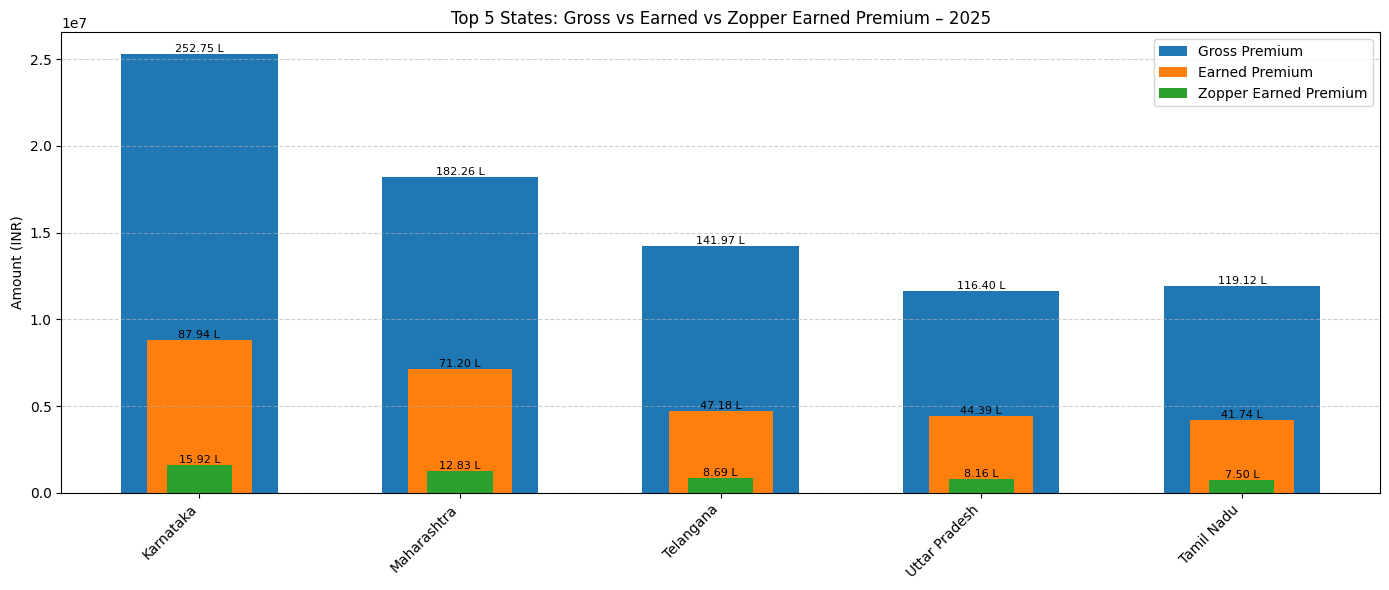

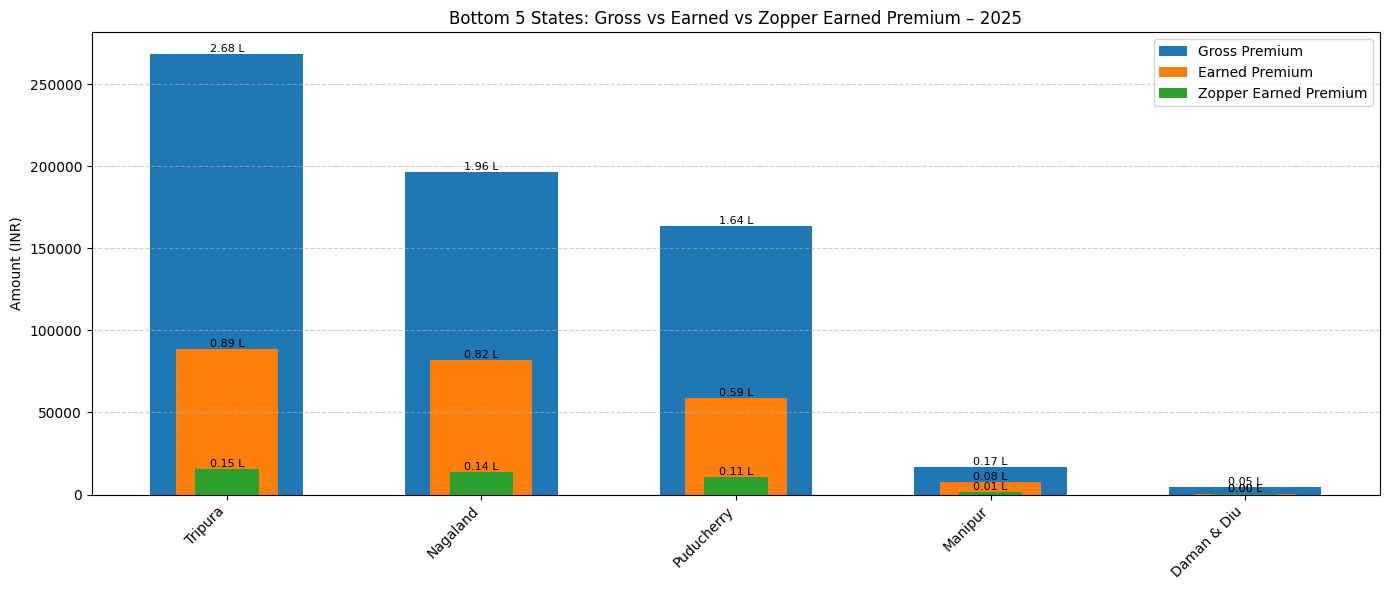

In [15]:
gross_premium_by_brand = (
    df_sales_25
    .groupby('State')['Gross Premium']
    .sum()
)

earned_premium_by_brand = (
    df_sales_25
    .groupby('State')['Earned Premium']
    .sum()
)

zopper_earned_by_brand = (
    df_sales_25
    .groupby('State')['Zopper Earned Premium']
    .sum()
)

brand_data = (
    pd.concat(
        [
            gross_premium_by_brand,
            earned_premium_by_brand,
            zopper_earned_by_brand
        ],
        axis=1
    )
    .fillna(0)
)

brand_data.columns = [
    'Gross Premium',
    'Earned Premium',
    'Zopper Earned Premium'
]

brand_data = brand_data.sort_values('Earned Premium', ascending=False)

top5 = brand_data.head(5)
bottom5 = brand_data.tail(5)

def plot_nested_bar(data, title):
    x = np.arange(len(data))

    fig, ax = plt.subplots(figsize=(14, 6))

    b0 = ax.bar(x, data['Gross Premium'], width=0.6, label='Gross Premium')
    b1 = ax.bar(x, data['Earned Premium'], width=0.4, label='Earned Premium')
    b2 = ax.bar(x, data['Zopper Earned Premium'], width=0.25, label='Zopper Earned Premium')

    ax.set_title(title)
    ax.set_ylabel('Amount (INR)')
    ax.set_xticks(x)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()

    for bars in [b0, b1, b2]:
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    h,
                    f'{h / 1e5:.2f} L',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

    plt.tight_layout()
    plt.show()

plot_nested_bar(
    top5,
    'Top 5 States: Gross vs Earned vs Zopper Earned Premium – 2025'
)

plot_nested_bar(
    bottom5,
    'Bottom 5 States: Gross vs Earned vs Zopper Earned Premium – 2025'
)


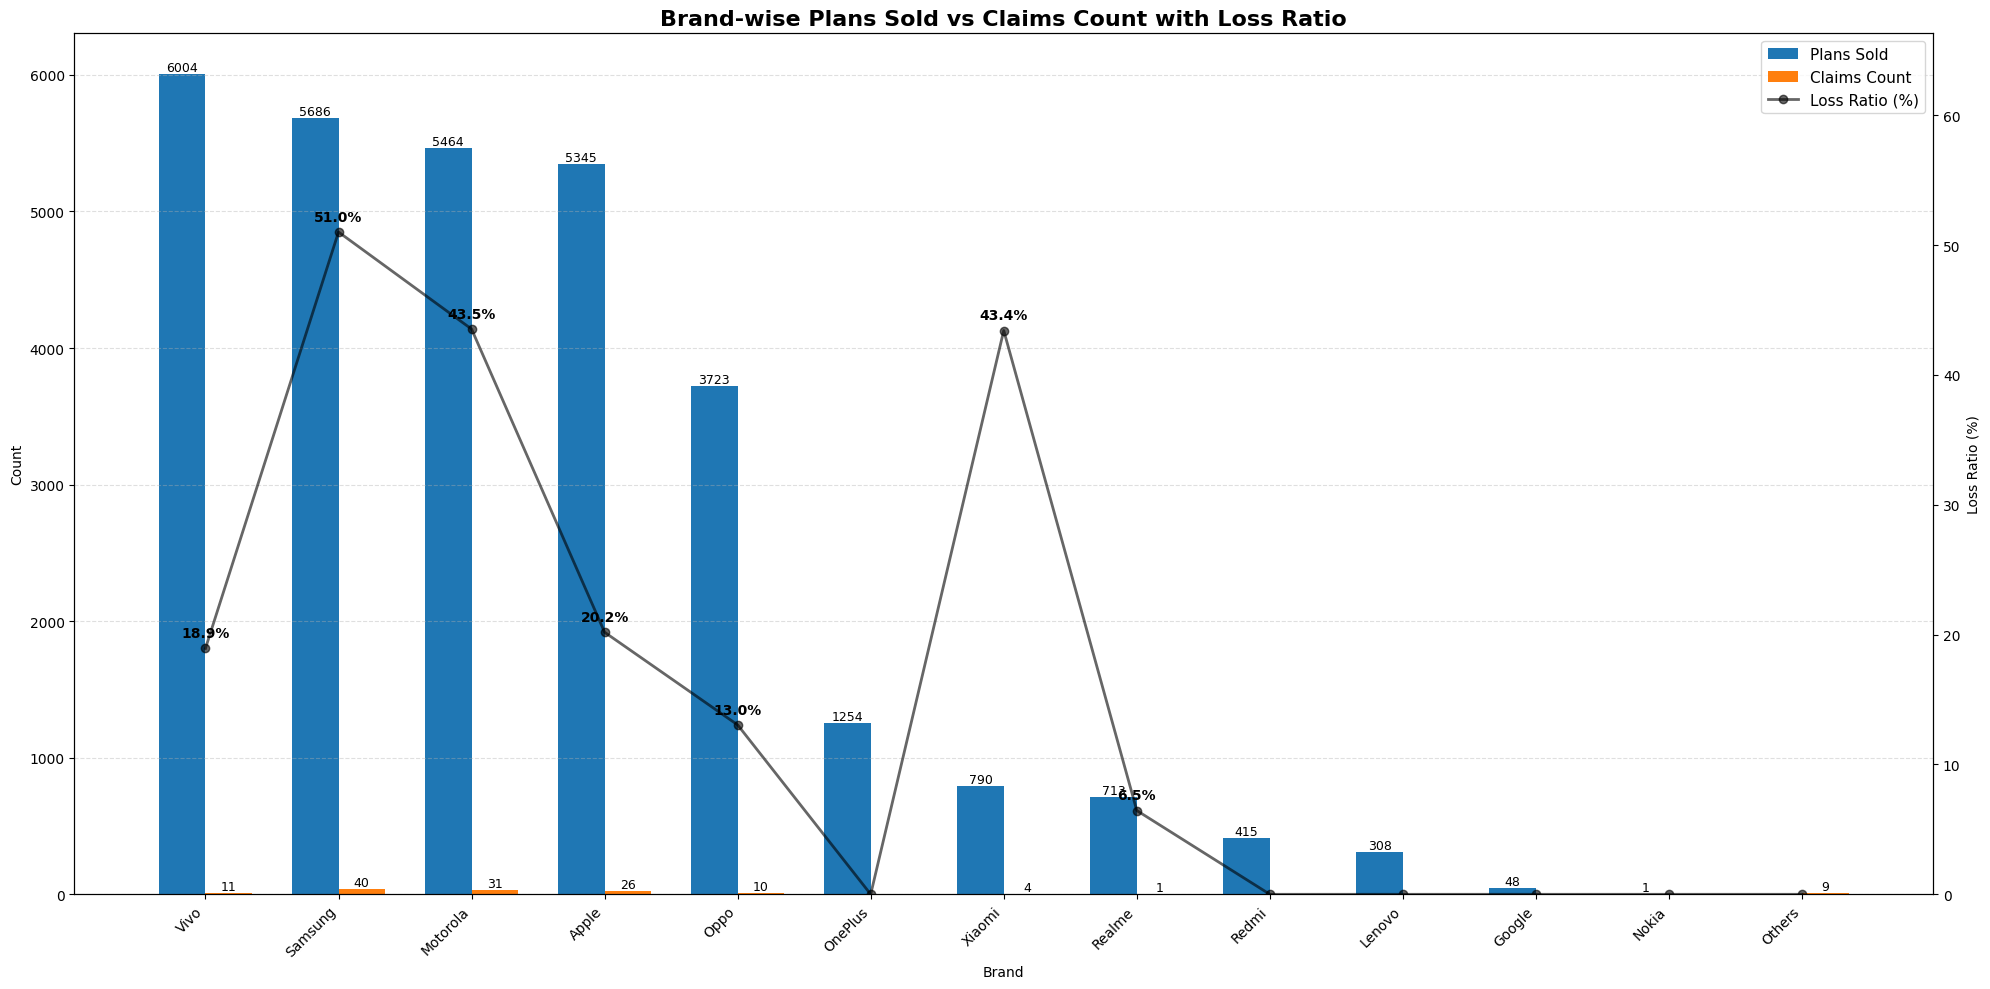

In [16]:
plans_by_brand = df_sales_25.groupby('Brand').size()
claims_by_brand = df_claims_25.groupby('Product Brand(Group)').size()

zopper_earned_by_brand = (
    df_sales_25
    .groupby('Brand')['Zopper Earned Premium']
    .sum()
)

zopper_claim_by_brand = (
    df_claims_25
    .groupby('Product Brand(Group)')["Zopper's Cost"]
    .sum()
)

deductible_by_brand = (
    df_claims_25
    .groupby('Product Brand(Group)')['One time deductible']
    .sum()
)

brand_data = (
    pd.concat(
        [
            plans_by_brand,
            claims_by_brand,
            zopper_earned_by_brand,
            zopper_claim_by_brand,
            deductible_by_brand
        ],
        axis=1
    )
    .fillna(0)
)

brand_data.columns = [
    'Plans Sold',
    'Claims Count',
    'Zopper Earned Premium',
    "Zopper's Cost",
    'One time deductible'
]

brand_data['Net Claims'] = (
    brand_data["Zopper's Cost"] - brand_data['One time deductible']
)

brand_data['Loss Ratio (%)'] = (
    brand_data['Net Claims'] / brand_data['Zopper Earned Premium'] * 100
).replace([np.inf, -np.inf], 0).fillna(0)

brand_data = brand_data.sort_values('Plans Sold', ascending=False)

x = np.arange(len(brand_data))
width = 0.35

fig, ax1 = plt.subplots(figsize=(20, 10))

b0 = ax1.bar(
    x - width/2,
    brand_data['Plans Sold'],
    width,
    label='Plans Sold'
)

b1 = ax1.bar(
    x + width/2,
    brand_data['Claims Count'],
    width,
    label='Claims Count'
)

ax1.set_title(
    'Brand-wise Plans Sold vs Claims Count with Loss Ratio',
    fontsize=16,
    fontweight='bold'
)

ax1.set_xlabel('Brand')
ax1.set_ylabel('Count')
ax1.set_xticks(x)
ax1.set_xticklabels(brand_data.index, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.4)

ax2 = ax1.twinx()

ax2.plot(
    x,
    brand_data['Loss Ratio (%)'],
    color='black',
    marker='o',
    linewidth=2,
    alpha=0.6,
    label='Loss Ratio (%)'
)

ax2.set_ylabel('Loss Ratio (%)')
ax2.set_ylim(0, brand_data['Loss Ratio (%)'].max() * 1.3)

for bars in [b0, b1]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                h,
                f'{int(h)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

for i, val in enumerate(brand_data['Loss Ratio (%)']):
    if val > 0:
        ax2.annotate(
            f'{val:.1f}%',
            xy=(x[i], val),
            xytext=(0, 8),
            textcoords='offset points',
            ha='center',
            fontsize=10,
            fontweight='bold'
        )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper right',
    fontsize=11
)

plt.tight_layout()
plt.show()


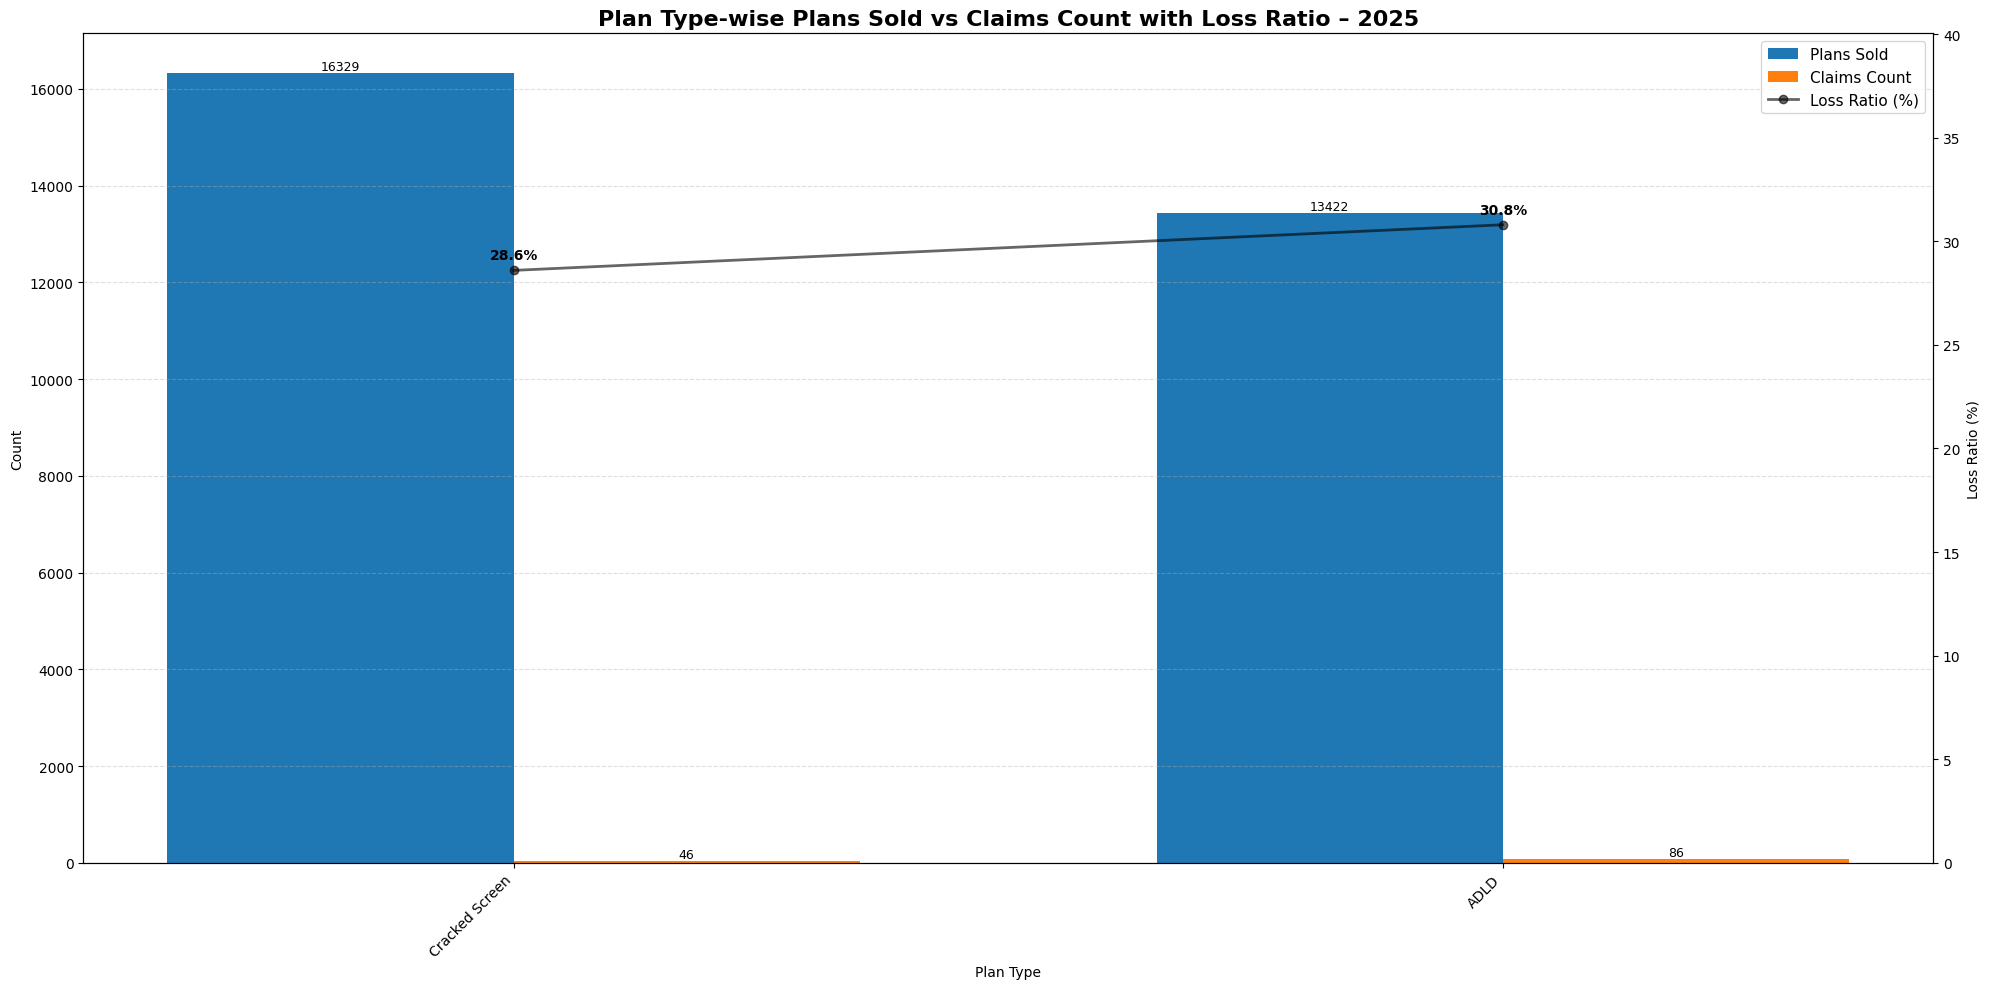

In [17]:
plans_by_plan = df_sales_25.groupby('Plan Type').size()
claims_by_plan = df_claims_25.groupby('Warranty Type').size()

zopper_earned_by_plan = (
    df_sales_25
    .groupby('Plan Type')['Zopper Earned Premium']
    .sum()
)

zopper_claim_by_plan = (
    df_claims_25
    .groupby('Warranty Type')["Zopper's Cost"]
    .sum()
)

deductible_by_plan = (
    df_claims_25
    .groupby('Warranty Type')['One time deductible']
    .sum()
)

plan_data = (
    pd.concat(
        [
            plans_by_plan,
            claims_by_plan,
            zopper_earned_by_plan,
            zopper_claim_by_plan,
            deductible_by_plan
        ],
        axis=1
    )
    .fillna(0)
)

plan_data.columns = [
    'Plans Sold',
    'Claims Count',
    'Zopper Earned Premium',
    "Zopper's Cost",
    'One time deductible'
]

plan_data['Net Claims'] = (
    plan_data["Zopper's Cost"] - plan_data['One time deductible']
)

plan_data['Loss Ratio (%)'] = (
    plan_data['Net Claims'] / plan_data['Zopper Earned Premium'] * 100
).replace([np.inf, -np.inf], 0).fillna(0)

plan_data = plan_data.sort_values('Plans Sold', ascending=False)

x = np.arange(len(plan_data))
width = 0.35

fig, ax1 = plt.subplots(figsize=(20, 10))

b0 = ax1.bar(
    x - width/2,
    plan_data['Plans Sold'],
    width,
    label='Plans Sold'
)

b1 = ax1.bar(
    x + width/2,
    plan_data['Claims Count'],
    width,
    label='Claims Count'
)

ax1.set_title(
    'Plan Type-wise Plans Sold vs Claims Count with Loss Ratio – 2025',
    fontsize=16,
    fontweight='bold'
)

ax1.set_xlabel('Plan Type')
ax1.set_ylabel('Count')
ax1.set_xticks(x)
ax1.set_xticklabels(plan_data.index, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.4)

ax2 = ax1.twinx()

ax2.plot(
    x,
    plan_data['Loss Ratio (%)'],
    color='black',
    marker='o',
    linewidth=2,
    alpha=0.6,
    label='Loss Ratio (%)'
)

ax2.set_ylabel('Loss Ratio (%)')
ax2.set_ylim(0, plan_data['Loss Ratio (%)'].max() * 1.3)

for bars in [b0, b1]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                h,
                f'{int(h)}',
                ha='center',
                va='bottom',
                fontsize=9
            )

for i, val in enumerate(plan_data['Loss Ratio (%)']):
    if val > 0:
        ax2.annotate(
            f'{val:.1f}%',
            xy=(x[i], val),
            xytext=(0, 8),
            textcoords='offset points',
            ha='center',
            fontsize=10,
            fontweight='bold'
        )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper right',
    fontsize=11
)

plt.tight_layout()
plt.show()


In [18]:
df_sales.columns

Index(['Plan Start Date', 'Month', 'Plan End Date', 'State',
       'Product Selling Price', 'Brand', 'Apple/And', 'Plan Type',
       'Plan Range', 'Plan Min', 'Plan Max', 'Transfer Price',
       'Plan Selling Price', 'Plan Duration',
       'Zopper Shared ( Transfer Price )'],
      dtype='object')

In [19]:
df_claims.columns

Index(['Call Code', 'Day of Call_Date', 'Day of Product Purchased Date 2',
       'Day of Repair Completion Date', 'Warranty Type',
       'Product Brand(Group)', 'Product Coverage', 'Claim_Amount',
       'Customer Paid', 'Last Estimation Amount (All Claims Report)',
       'One time deductible', 'Zopper's Cost'],
      dtype='object')

In [20]:
df_claims['purchase_to_claim_days'] = (
    pd.to_datetime(df_claims['Day of Call_Date']) -
    pd.to_datetime(df_claims['Day of Product Purchased Date 2'])
).dt.days

brand_return_table = (
    df_claims
    .groupby('Product Brand(Group)')['purchase_to_claim_days']
    .agg(
        Total_Claims='count',
        Avg_Return_Days='mean',
        Median_Return_Days='median',
        Min_Return_Days='min',
        Max_Return_Days='max'
    )
    .round(1)
    .reset_index()
)

brand_return_table


,Product Brand(Group),Total_Claims,Avg_Return_Days,Median_Return_Days,Min_Return_Days,Max_Return_Days
0,Apple,26,81.1,83.0,14,163
1,Motorola,37,46.9,43.0,3,121
2,OPPO,11,83.8,79.0,27,140
3,Others,9,51.0,46.0,4,78
4,Realme,1,51.0,51.0,51,51
5,Samsung,43,71.3,62.0,8,154
6,Vivo,12,66.4,61.0,17,153
7,Xiaomi,5,48.6,51.0,20,78


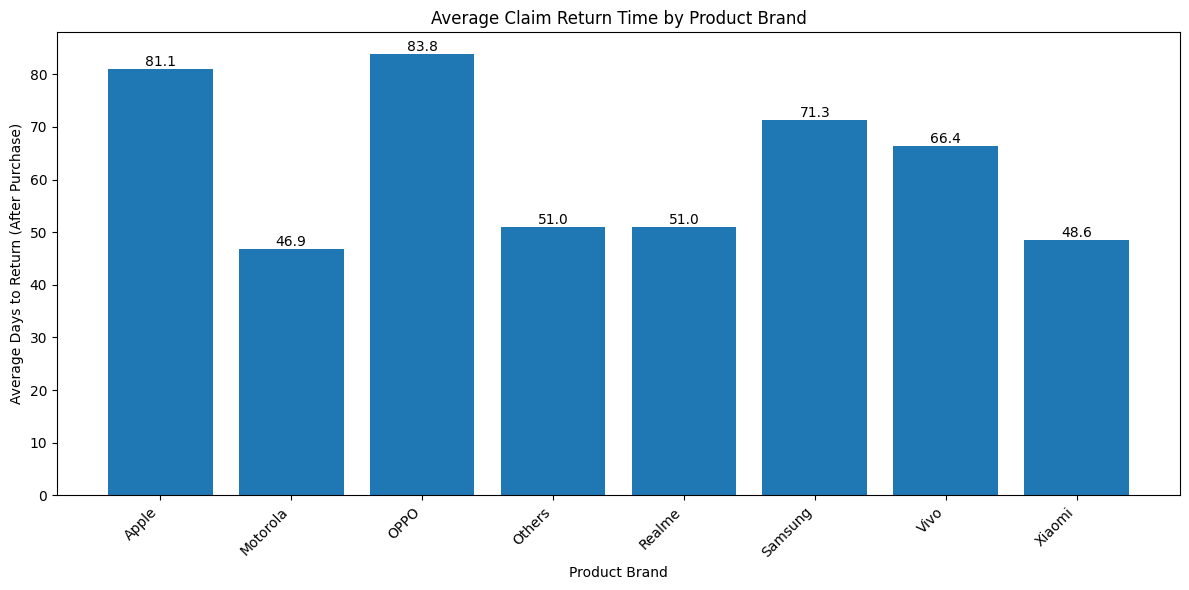

In [21]:
plt.figure(figsize=(12, 6))

bars = plt.bar(
    brand_return_table['Product Brand(Group)'],
    brand_return_table['Avg_Return_Days']
)

plt.xlabel('Product Brand')
plt.ylabel('Average Days to Return (After Purchase)')
plt.title('Average Claim Return Time by Product Brand')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


In [22]:
bins = [-1, 7, 30, 90, 10_000]
labels = ['0-7 days', '8-30 days', '31-90 days', '90+ days']

df_claims['purchase_claim_bucket'] = pd.cut(
    df_claims['purchase_to_claim_days'],
    bins=bins,
    labels=labels
)

brand_bucket_pivot = (
    df_claims
    .groupby(['Product Brand(Group)', 'purchase_claim_bucket'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

brand_bucket_pivot


C:\Users\yogan\AppData\Local\Temp\ipykernel_19792\3742723393.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Product Brand(Group)', 'purchase_claim_bucket'])


purchase_claim_bucket,Product Brand(Group),0-7 days,8-30 days,31-90 days,90+ days
0,Apple,0,5,9,12
1,Motorola,1,9,22,5
2,OPPO,0,1,6,4
3,Others,1,0,8,0
4,Realme,0,0,1,0
5,Samsung,0,6,23,14
6,Vivo,0,2,8,2
7,Xiaomi,0,1,4,0


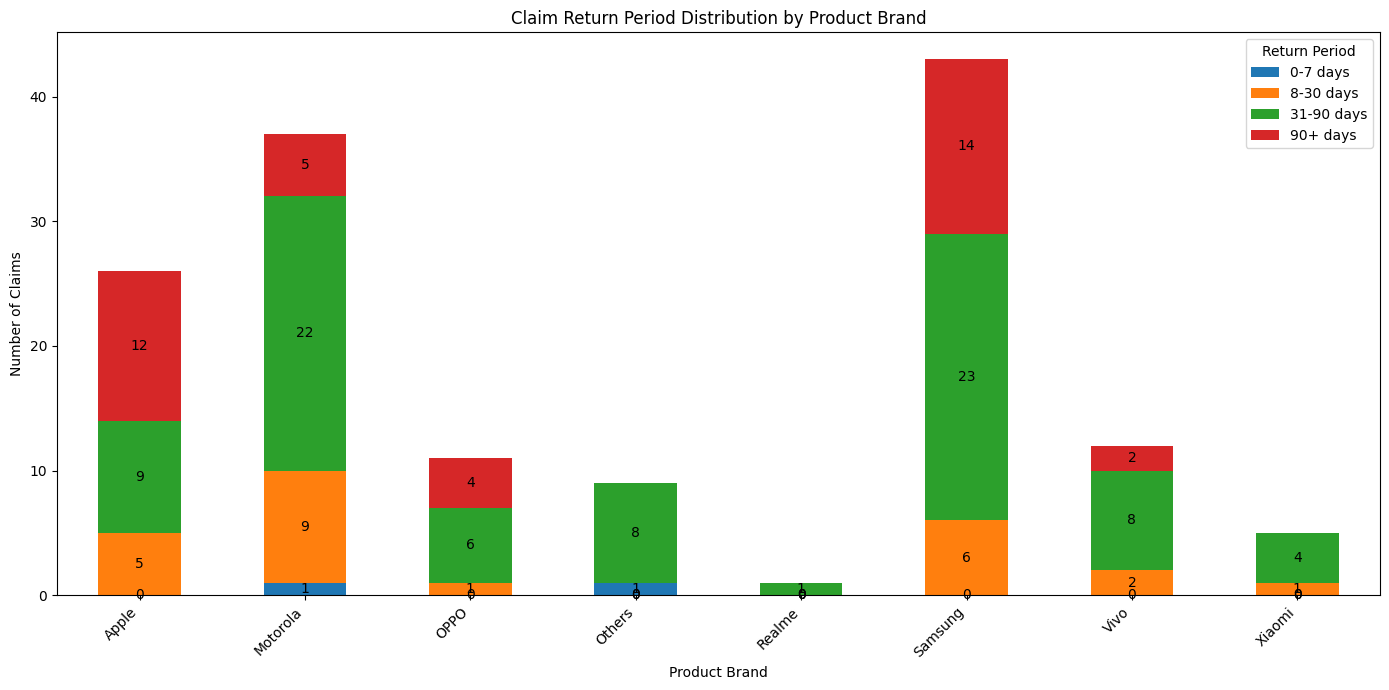

In [23]:
ax = brand_bucket_pivot.set_index('Product Brand(Group)')[labels].plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7)
)

plt.xlabel('Product Brand')
plt.ylabel('Number of Claims')
plt.title('Claim Return Period Distribution by Product Brand')

plt.xticks(rotation=45, ha='right')
plt.legend(title='Return Period')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()


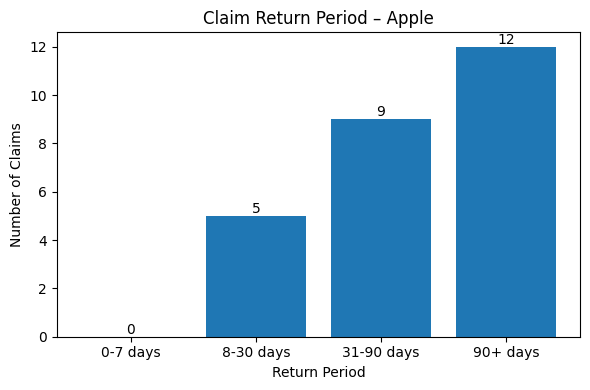

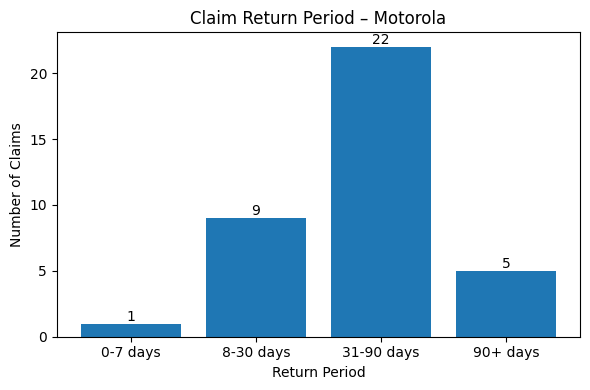

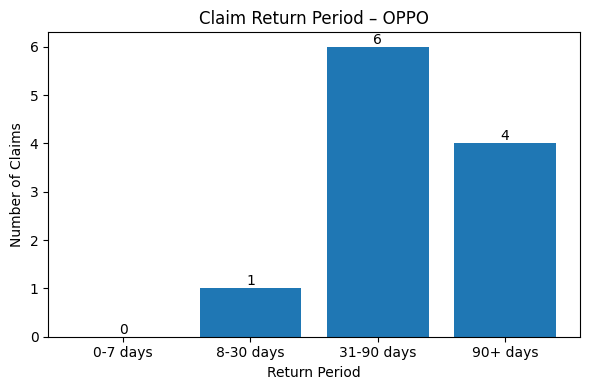

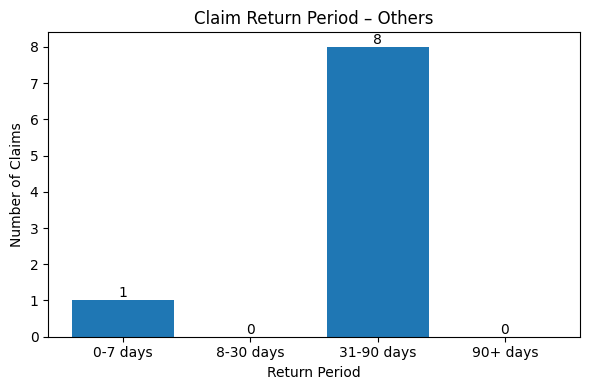

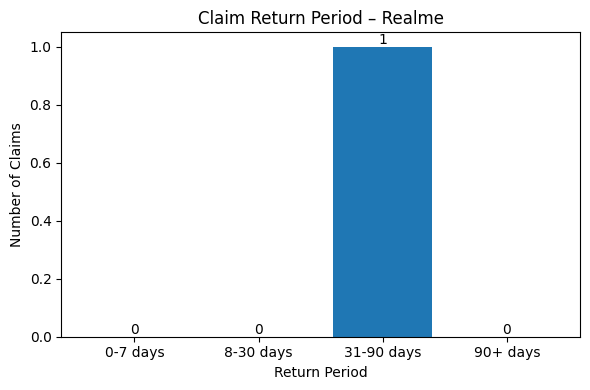

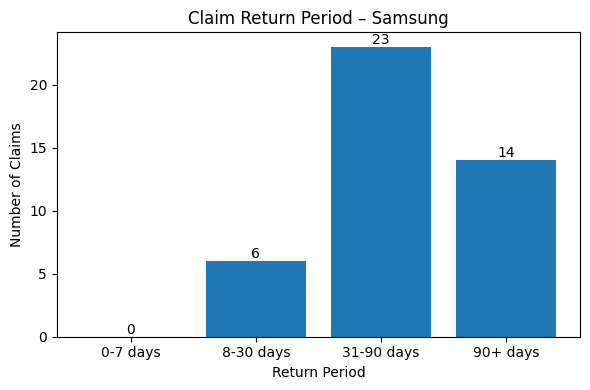

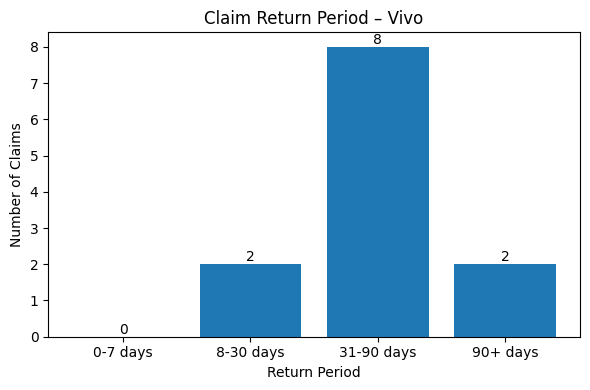

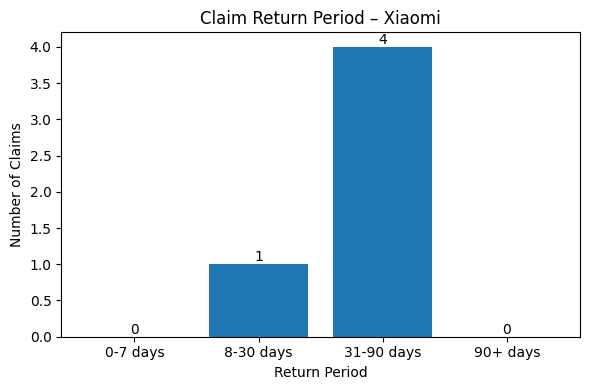

In [ ]:
for brand, data in brand_bucket_pivot.groupby('Product Brand(Group)'):
    values = data[labels].iloc[0]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values)

    plt.xlabel('Return Period')
    plt.ylabel('Number of Claims')
    plt.title(f'Claim Return Period – {brand}')

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            int(height),
            ha='center',
            va='bottom'
        )

    plt.tight_layout()
    plt.show()


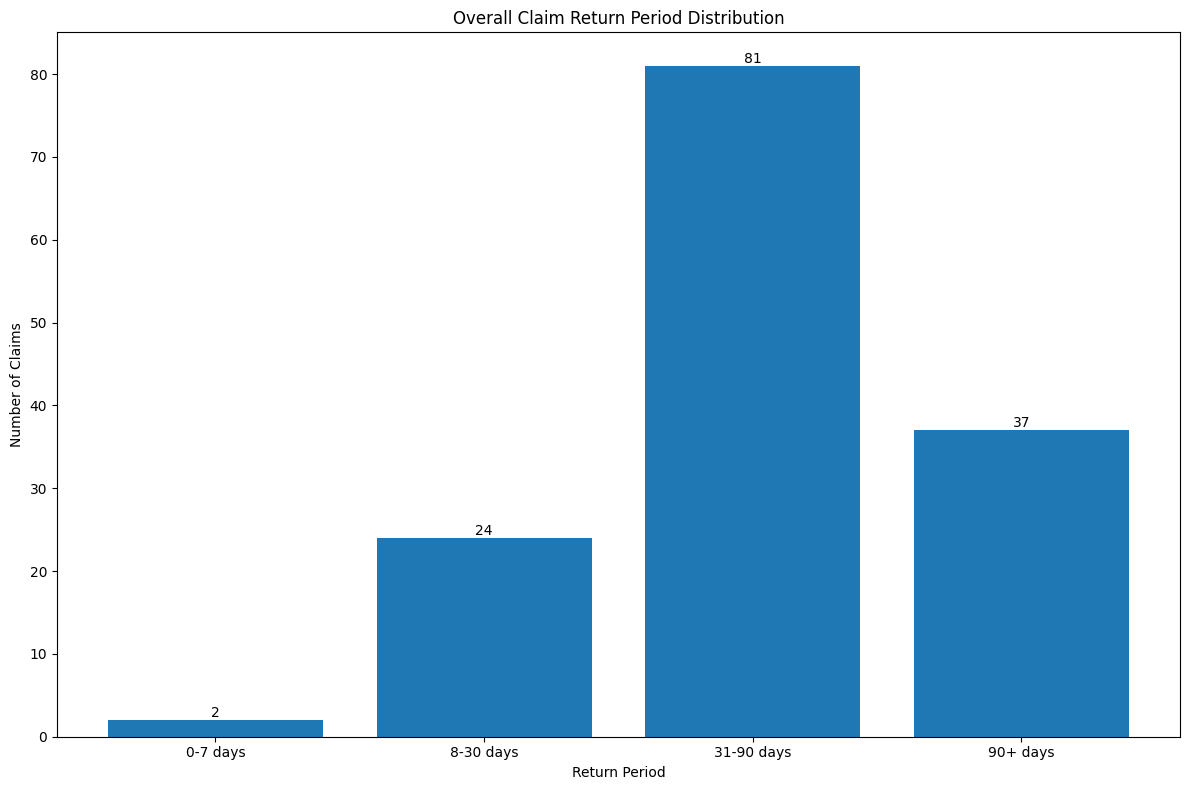

In [37]:
overall_bucket_counts = brand_bucket_pivot[labels].sum()

plt.figure(figsize=(12, 8))
bars = plt.bar(labels, overall_bucket_counts)

plt.xlabel('Return Period')
plt.ylabel('Number of Claims')
plt.title('Overall Claim Return Period Distribution')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        int(height),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


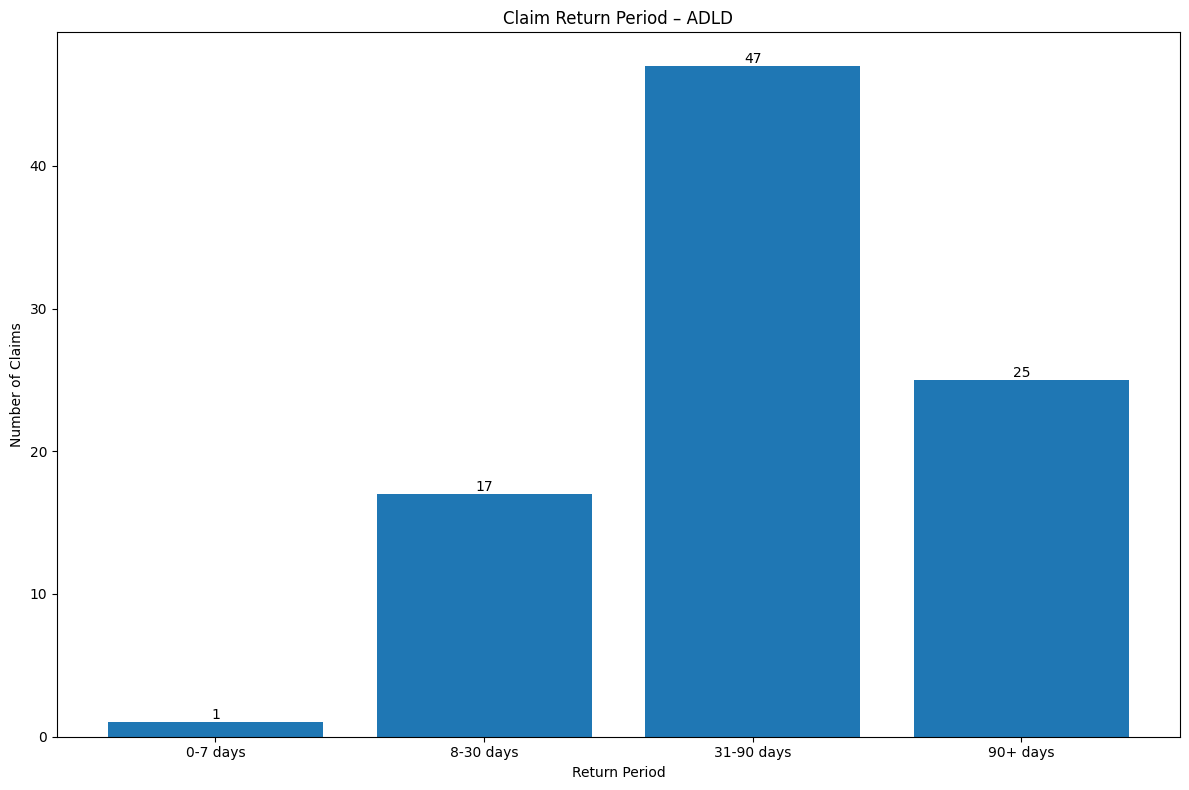

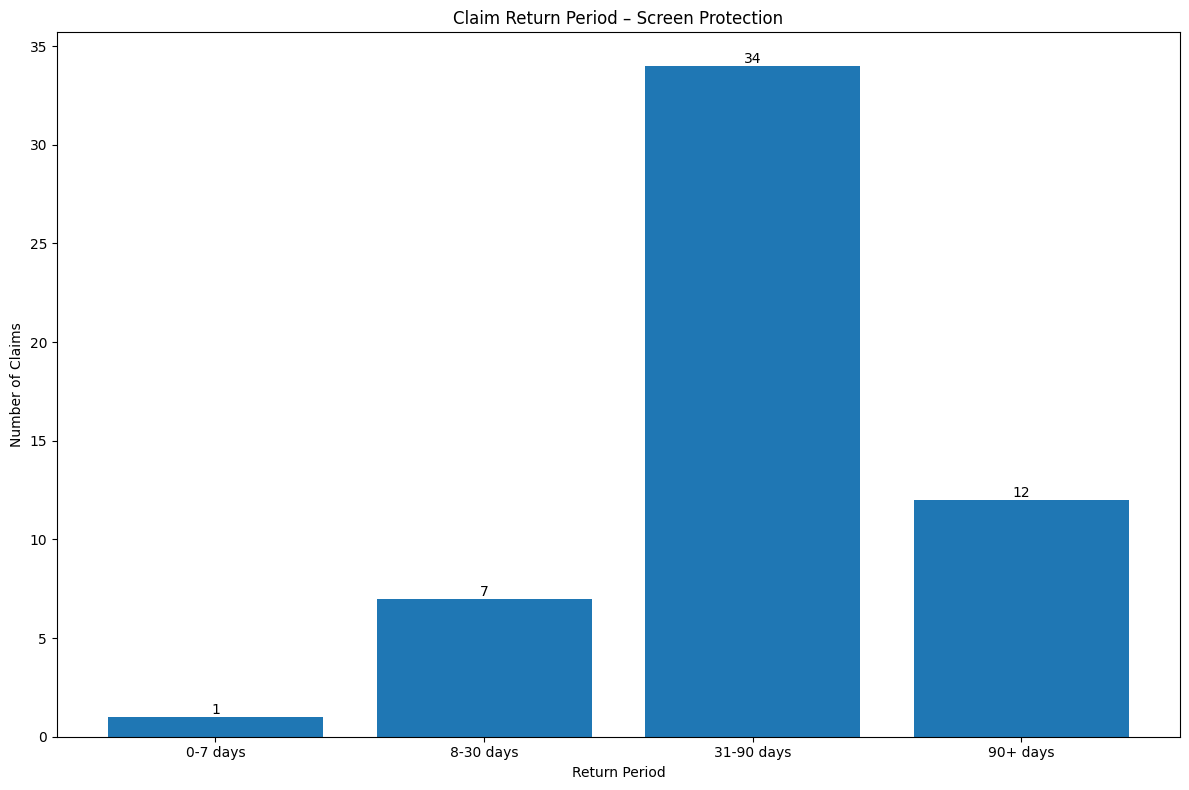

In [40]:
for plan_type, data in df_claims.groupby('Warranty Type'):
    bucket_counts = (
        data['purchase_claim_bucket']
        .value_counts()
        .reindex(labels, fill_value=0)
    )

    plt.figure(figsize=(12, 8))
    bars = plt.bar(labels, bucket_counts)

    plt.xlabel('Return Period')
    plt.ylabel('Number of Claims')
    plt.title(f'Claim Return Period – {plan_type}')

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            int(height),
            ha='center',
            va='bottom'
        )

    plt.tight_layout()
    plt.show()


In [25]:
df_claims_25['call_date'] = pd.to_datetime(df_claims['Day of Call_Date'])

monthly_claims = (
    df_claims_25
    .set_index('call_date')
    .resample('M')
    .size()
    .rename('claims')
)

monthly_claims_aug_dec = monthly_claims[
    monthly_claims.index.month.isin([8, 9, 10, 11, 12])
]

monthly_claims_aug_dec

C:\Users\yogan\AppData\Local\Temp\ipykernel_19792\4168533534.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


call_date
2025-08-31     7
2025-09-30    13
2025-10-31    24
2025-11-30    44
2025-12-31    44
Freq: ME, Name: claims, dtype: int64

In [26]:
claims = monthly_claims_aug_dec.values[-3:]
weights = np.array([0.2, 0.3, 0.5])

jan_2026_pred_wma = int(np.dot(claims, weights))
jan_2026_pred_wma

40

In [27]:
y = monthly_claims_aug_dec.values
x = np.arange(len(y))

coef = np.polyfit(x, y, 1)
jan_2026_pred_trend = int(np.polyval(coef, len(y)))
jan_2026_pred_trend


57

In [28]:

jan_2026_pred_avg = int(y.mean())
jan_2026_pred_avg


26

In [29]:
recent = monthly_claims_aug_dec.values[-3:]

growth_rates = recent[1:] / recent[:-1]
avg_growth = growth_rates.mean()

level = monthly_claims_aug_dec.values[-3:].mean()
drift = (monthly_claims_aug_dec.values[-1] - monthly_claims_aug_dec.values[-3]) / 2

jan_2026_pred = int(level + 0.5 * drift)
jan_2026_pred


42

In [30]:
df_sales_25 = df_sales_25.copy()
len(df_sales_25)

# df_sales_25['Month'].unique()



29751

In [31]:
df_sales_25['Plan Start Date'] = pd.to_datetime(df_sales_25['Plan Start Date'], errors='coerce')

df_sales_25['Plan Start Date'].dt.month_name().value_counts()


Plan Start Date
December     5465
November     4820
July         4122
October      3470
August       3317
September    3091
February     1079
March        1031
January       902
May           843
June          813
April         798
Name: count, dtype: int64

In [32]:
monthly_sales = df_sales_25['Month'].astype(str).str.strip().value_counts()
monthly_sales


month_order = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_sales = (
    df_sales_25['Month']
    .value_counts()
    .reindex(month_order)
)

monthly_sales

Month
Jul    3951
Aug    4030
Sep    3464
Oct    4363
Nov    6538
Dec    7405
Name: count, dtype: int64

In [ ]:
recent = monthly_sales[-3:].values
growth = (recent[1:] / recent[:-1]).mean()
damped_growth = min(growth, 1.15)

jan_pred = int(recent[-1] * damped_growth)
print('January Prediction:',jan_pred)

8515

In [41]:
def damped_growth_prediction(series, cap=1.15):
    recent = series[-3:]
    growth = (recent[1:] / recent[:-1]).mean()
    damped_growth = min(growth, cap)
    return int(recent[-1] * damped_growth)


# ---------------- SALES ---------------- #

# monthly_sales assumed ordered: Jul → Dec
sales_series = monthly_sales.values

# Predict DEC using data till NOV
sales_pred_dec = damped_growth_prediction(sales_series[:-1])
sales_actual_dec = sales_series[-1]

# Predict JAN using data till DEC
sales_pred_jan = damped_growth_prediction(sales_series)


# ---------------- CLAIMS ---------------- #

# monthly_claims assumed ordered: Aug → Dec
claims_series = monthly_claims.values

# Predict DEC using data till NOV
claims_pred_dec = damped_growth_prediction(claims_series[:-1])
claims_actual_dec = claims_series[-1]

# Predict JAN using data till DEC
claims_pred_jan = damped_growth_prediction(claims_series)


# ---------------- PRINT RESULTS ---------------- #

print("📦 SALES PREDICTION")
print(f"Predicted DEC Sales (using Jul–Nov): {sales_pred_dec}")
print(f"Actual DEC Sales               : {sales_actual_dec}")
print(f"Predicted JAN Sales (using Jul–Dec): {sales_pred_jan}")
print()

print("📞 CLAIMS PREDICTION")
print(f"Predicted DEC Claims (using Aug–Nov): {claims_pred_dec}")
print(f"Actual DEC Claims               : {claims_actual_dec}")
print(f"Predicted JAN Claims (using Aug–Dec): {claims_pred_jan}")


📦 SALES PREDICTION
Predicted DEC Sales (using Jul–Nov): 7518
Actual DEC Sales               : 7405
Predicted JAN Sales (using Jul–Dec): 8515

📞 CLAIMS PREDICTION
Predicted DEC Claims (using Aug–Nov): 50
Actual DEC Claims               : 44
Predicted JAN Claims (using Aug–Dec): 50


C:\Users\yogan\AppData\Local\Temp\ipykernel_19792\1881613259.py:23: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


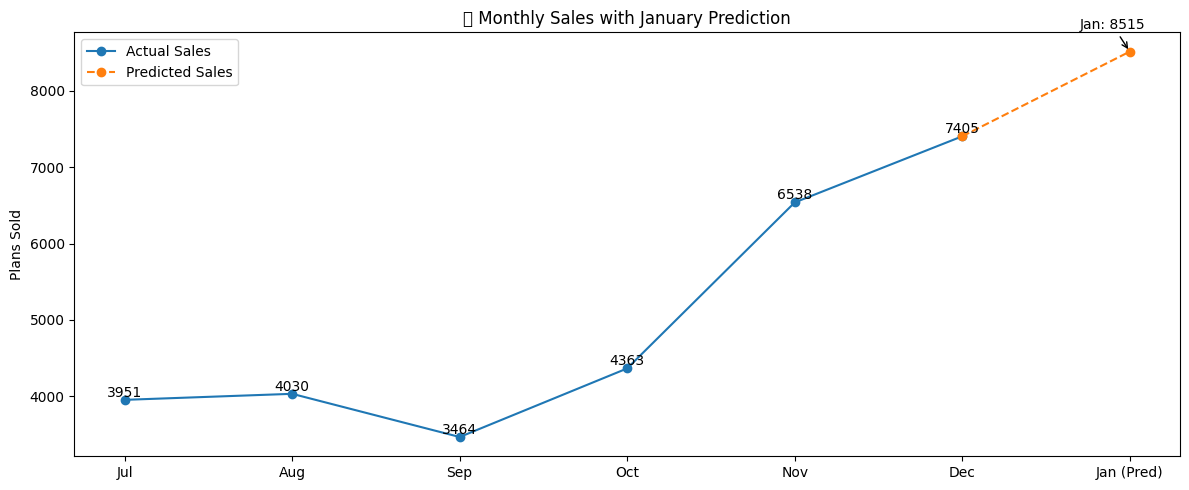

In [50]:
import matplotlib.pyplot as plt

months_sales = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan (Pred)']
sales_values = [*monthly_sales.values, sales_pred_jan]

plt.figure(figsize=(12, 5))
plt.plot(months_sales[:-1], sales_values[:-1], marker='o', label='Actual Sales')
plt.plot(months_sales[-2:], sales_values[-2:], linestyle='--', marker='o', label='Predicted Sales')

plt.annotate(
    f"Jan: {sales_pred_jan}",
    xy=(len(months_sales)-1, sales_pred_jan),
    xytext=(len(months_sales)-1.3, sales_pred_jan + 300),
    arrowprops=dict(arrowstyle="->")
)

for i, val in enumerate(sales_values[:-1]):
    plt.text(i, val, str(val), ha='center', va='bottom')

plt.title("📦 Monthly Sales with January Prediction")
plt.ylabel("Plans Sold")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\yogan\AppData\Local\Temp\ipykernel_19792\550411008.py:21: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


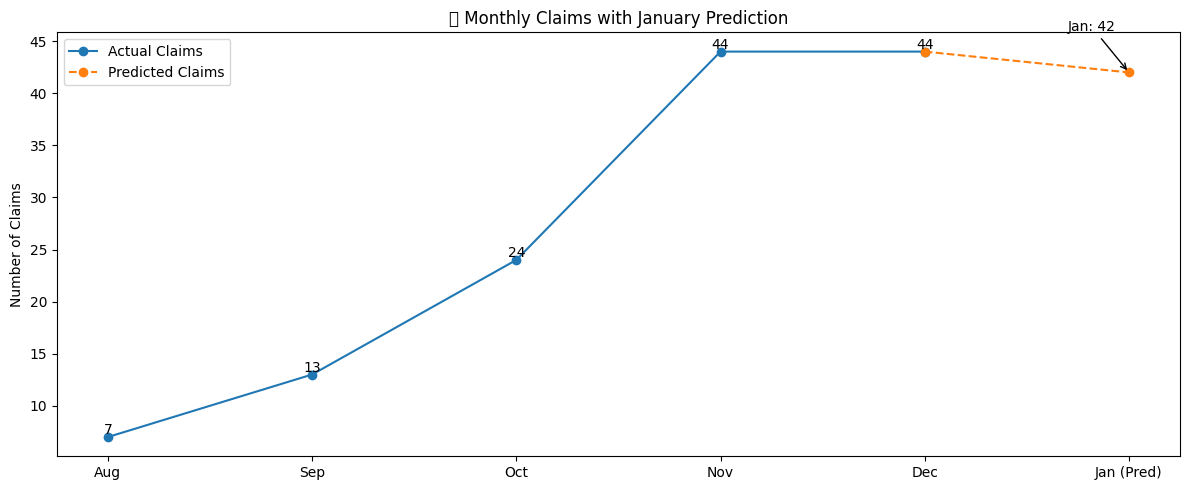

In [47]:
months_claims = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan (Pred)']
claims_values = [*monthly_claims.values, jan_2026_pred]

plt.figure(figsize=(12, 5))
plt.plot(months_claims[:-1], claims_values[:-1], marker='o', label='Actual Claims')
plt.plot(months_claims[-2:], claims_values[-2:], linestyle='--', marker='o', label='Predicted Claims')

plt.annotate(
    f"Jan: {jan_2026_pred}",
    xy=(len(months_claims)-1, jan_2026_pred),
    xytext=(len(months_claims)-1.3, jan_2026_pred + 4),
    arrowprops=dict(arrowstyle="->")
)

for i, val in enumerate(monthly_claims.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

plt.title("📞 Monthly Claims with January Prediction")
plt.ylabel("Number of Claims")
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
# -------- SALES ACCURACY (DEC VALIDATION) -------- #

sales_actual_dec = sales_actual_dec
sales_pred_dec = sales_pred_dec

sales_abs_error = abs(sales_pred_dec - sales_actual_dec)
sales_pct_error = (sales_abs_error / sales_actual_dec) * 100
sales_accuracy = 100 - sales_pct_error


# -------- CLAIMS ACCURACY (DEC VALIDATION) -------- #

claims_actual_dec = claims_actual_dec
claims_pred_dec = claims_pred_dec

claims_abs_error = abs(claims_pred_dec - claims_actual_dec)
claims_pct_error = (claims_abs_error / claims_actual_dec) * 100
claims_accuracy = 100 - claims_pct_error


# -------- PRINT RESULTS -------- #

print("📦 SALES MODEL ACCURACY (DEC VALIDATION)")
print(f"Predicted DEC Sales : {sales_pred_dec}")
print(f"Actual DEC Sales    : {sales_actual_dec}")
print(f"Absolute Error      : {sales_abs_error}")
print(f"Percentage Error    : {sales_pct_error:.2f}%")
print(f"Model Accuracy      : {sales_accuracy:.2f}%")
print()

print("📞 CLAIMS MODEL ACCURACY (DEC VALIDATION)")
print(f"Predicted DEC Claims : {claims_pred_dec}")
print(f"Actual DEC Claims    : {claims_actual_dec}")
print(f"Absolute Error       : {claims_abs_error}")
print(f"Percentage Error     : {claims_pct_error:.2f}%")
print(f"Model Accuracy       : {claims_accuracy:.2f}%")


📦 SALES MODEL ACCURACY (DEC VALIDATION)
Predicted DEC Sales : 7518
Actual DEC Sales    : 7405
Absolute Error      : 113
Percentage Error    : 1.53%
Model Accuracy      : 98.47%

📞 CLAIMS MODEL ACCURACY (DEC VALIDATION)
Predicted DEC Claims : 50
Actual DEC Claims    : 44
Absolute Error       : 6
Percentage Error     : 13.64%
Model Accuracy       : 86.36%
